# Model Training with LSTM Autoencoder

Model trained with the data which is manually numerized and used sliding window

### Loading the data:

* Firstly we are importing and downloading necesarry files.

In [12]:
import pandas as pd
import numpy as np
import tensorflow as tf #for machine learning and ai generating

In [13]:
from sklearn.preprocessing import StandardScaler, RobustScaler #machine learning, z=X-μ/σ, Xscaled= Xmax−Xmin / X−Xmin
from tensorflow.keras.models import Sequential, Model #ai, Sequential is the simplest way to build neural networks
from tensorflow.keras.layers import LSTM, Input, Dense, Dropout, RepeatVector, TimeDistributed #LSTM:memory algo, dense: fully connecting layers, dropout: regularization technique, repeatvectore:Repeats the input vector to create a sequence
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [43]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import matplotlib.pyplot as plt # visualization

In [15]:
# Dictionary with dataset names and their raw GitHub URLs
datasets = {
    "TrainSet": "https://raw.githubusercontent.com/sabisay/AnomalyDetectionOnLogDatas/refs/heads/main/DatasetsAfterPreprocess/df_train.csv",
    "CVSet": "https://raw.githubusercontent.com/sabisay/AnomalyDetectionOnLogDatas/refs/heads/main/DatasetsAfterPreprocess/df_cv.csv",
    "TestSet": "https://raw.githubusercontent.com/sabisay/AnomalyDetectionOnLogDatas/refs/heads/main/DatasetsAfterPreprocess/df_test.csv",
}

# Load datasets seperately
df_train = pd.read_csv(datasets["TrainSet"])
df_cv = pd.read_csv(datasets["CVSet"])
df_test = pd.read_csv(datasets["TestSet"])

In [16]:
datasets_2 = {
    "cv_labeled" : "https://raw.githubusercontent.com/sabisay/AnomalyDetectionOnLogDatas/refs/heads/main/DatasetsAfterPreprocess/df_labeled_cv.csv",
    "test_labeled" : "https://raw.githubusercontent.com/sabisay/AnomalyDetectionOnLogDatas/refs/heads/main/DatasetsAfterPreprocess/df_labeled_test.csv"
}

df_cv_labeled = pd.read_csv(datasets_2["cv_labeled"])
df_test_labeled = pd.read_csv(datasets_2["test_labeled"])



*   Remove unnecessary columns


In [22]:
df_train = df_train.drop(columns=["Department", "UserRole", "AccessLevel", "DeviceID", "IsAccessFail"])
df_cv = df_cv.drop(columns=["Department", "UserRole", "AccessLevel", "DeviceID", "IsAccessFail"])
df_test = df_test.drop(columns=["Department", "UserRole", "AccessLevel", "DeviceID", "IsAccessFail"])



*   Bcs of LSTM learns from differentiation in time we need to sort the data


In [23]:
df_train_sorted = df_train.sort_values(by="Timestamp").reset_index(drop=True)
df_cv_sorted = df_cv.sort_values(by="Timestamp").reset_index(drop=True)
df_test_sorted = df_test.sort_values(by="Timestamp").reset_index(drop=True)
df_labeled_cv_sorted = df_cv_labeled.sort_values(by="Timestamp").reset_index(drop=True)
df_labeled_test_sorted = df_test_labeled.sort_values(by="Timestamp").reset_index(drop=True)



*   Applyin normalization

In [24]:
# Assuming 'Timestamp' is the datetime column
datetime_cols = ['Timestamp']

# Convert datetime columns to numerical representation (e.g., Unix timestamp)
for col in datetime_cols:
    df_train_sorted[col] = pd.to_datetime(df_train_sorted[col]).view(np.int64) // 10**9  # Convert to Unix timestamp in seconds
    df_cv_sorted[col] = pd.to_datetime(df_cv_sorted[col]).view(np.int64) // 10**9  # Convert to Unix timestamp in seconds
    df_test_sorted[col] = pd.to_datetime(df_test_sorted[col]).view(np.int64) // 10**9 # Convert to Unix timestamp in seconds

## We did not use min max scaler bcs each set could have its own min and max values and it could be confusing for lstm.
scaler = RobustScaler()
train_scaled = scaler.fit_transform(df_train_sorted)
cv_scaled = scaler.transform(df_cv_sorted)
test_scaled = scaler.transform(df_test_sorted)

<ipython-input-24-06598accf97f>:6: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df_train_sorted[col] = pd.to_datetime(df_train_sorted[col]).view(np.int64) // 10**9  # Convert to Unix timestamp in seconds
<ipython-input-24-06598accf97f>:7: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df_cv_sorted[col] = pd.to_datetime(df_cv_sorted[col]).view(np.int64) // 10**9  # Convert to Unix timestamp in seconds
<ipython-input-24-06598accf97f>:8: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df_test_sorted[col] = pd.to_datetime(df_test_sorted[col]).view(np.int64) // 10**9 # Convert to Unix timestamp in seconds


Sliding Window gets 3 dimensional input. We are creating sequences as sliding windows with time steps.

In [25]:
def create_sequences(data, time_steps=10):
    sequences = []
    indices = []
    for i in range(len(data) - time_steps+1):
        seq = data[i:i+time_steps]
        sequences.append(seq)
        indices.append(i + time_steps - 1)
    return np.array(sequences), indices

TIME_STEPS = 10
train_seq, indices = create_sequences(train_scaled, TIME_STEPS)

Defining Model:

In [26]:
# 🤖 Build LSTM Autoencoder
timesteps, features = train_seq.shape[1], train_seq.shape[2]

inputs = Input(shape=(timesteps, features))
encoded = LSTM(64, activation='relu', return_sequences=False)(inputs)
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
outputs = TimeDistributed(Dense(features))(decoded)

autoencoder = Model(inputs, outputs)

Compile Model

In [27]:
autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(
    train_seq, train_seq,  # both input and target are X_train
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 0.1675 - val_loss: 0.1432
Epoch 2/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.1542 - val_loss: 0.1274
Epoch 3/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.1379 - val_loss: 0.1290
Epoch 4/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.1281 - val_loss: 0.1202
Epoch 5/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.1201 - val_loss: 0.1175
Epoch 6/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.1150 - val_loss: 0.1073
Epoch 7/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.1104 - val_loss: 0.1111
Epoch 8/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.1088 - val_loss: 0.1011
Epoch 9/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.1039 - val_loss: 0.1005
Epoch 10/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.1008 - val_loss: 0.0904
Epoch 11/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0992 - val_loss: 0.0890
Epoch 12/50
844/844 ━━━━━━━━━━━━━

Training - Validation Loss:

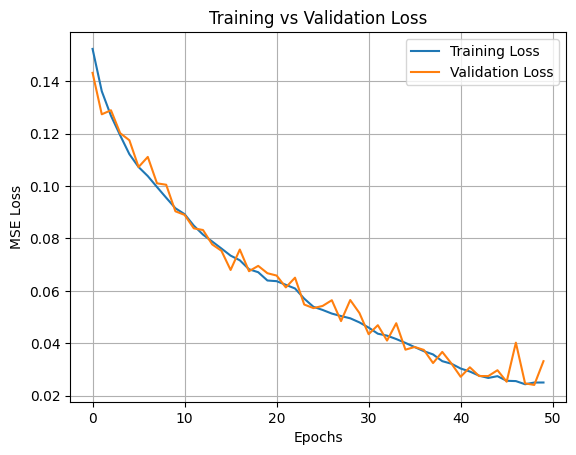

In [28]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()

Normalization of other datasets

In [29]:
TIME_STEPS = 10
cv_seq, cv_indices = create_sequences(cv_scaled, TIME_STEPS)
test_seq, test_indices = create_sequences(test_scaled, TIME_STEPS)

In [69]:
# 📊 Evaluate reconstruction error
def get_reconstruction_error(data_seq):
    recon = autoencoder.predict(data_seq)
    return np.mean(np.mean(np.square(data_seq - recon), axis=2), axis=1)

train_error = get_reconstruction_error(train_seq)
threshold = np.percentile(train_error, 99.98)

cv_error = get_reconstruction_error(cv_seq)
test_error = get_reconstruction_error(test_seq)

cv_pred = (cv_error > threshold).astype(int)
test_pred = (test_error > threshold).astype(int)

print(f"Anomali eşik değeri (99. percentil): {threshold:.6f}")

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Anomali eşik değeri (99. percentil): 0.264095


Calculating Reconstruction Errors:

In [70]:
cv_anomalies = cv_error > threshold
test_anomalies = test_error > threshold

print(f"Detected {np.sum(cv_anomalies)} anomalies out of {len(cv_error)} CV sequences.")
print(f"Detected {np.sum(test_anomalies)} anomalies out of {len(test_error)} test sequences.")

Detected 245 anomalies out of 19991 CV sequences.
Detected 208 anomalies out of 19991 test sequences.


CV Classification Report:
              precision    recall  f1-score   support

           0     0.9885    0.9883    0.9884     19760
           1     0.0531    0.0542    0.0536       240

    accuracy                         0.9770     20000
   macro avg     0.5208    0.5212    0.5210     20000
weighted avg     0.9773    0.9770    0.9772     20000



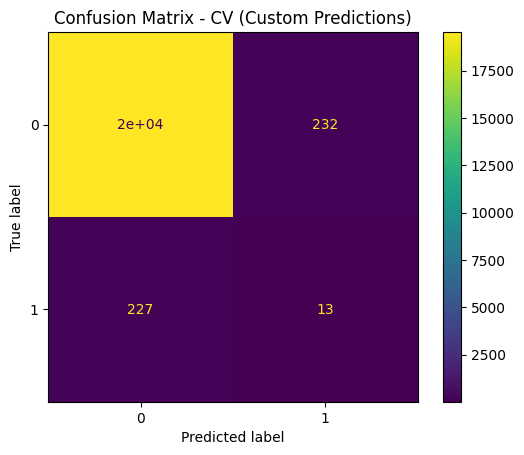

Test Classification Report:
              precision    recall  f1-score   support

           0     0.9884    0.9901    0.9893     19759
           1     0.0577    0.0498    0.0535       241

    accuracy                         0.9788     20000
   macro avg     0.5231    0.5199    0.5214     20000
weighted avg     0.9772    0.9788    0.9780     20000



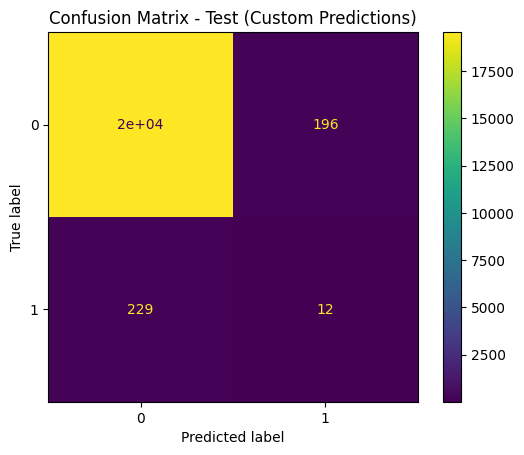

In [71]:
# Initialize predicted labels for each row as 0
cv_preds = np.zeros(len(df_cv_sorted))
test_preds = np.zeros(len(df_test_sorted))

# Mark rows that were the last point of an anomalous sequence as 1
for i, is_anomaly in zip(cv_indices, cv_anomalies):
    if is_anomaly:
        cv_preds[i] = 1

for i, is_anomaly in zip(test_indices, test_anomalies):
    if is_anomaly:
        test_preds[i] = 1

# True labels from your labeled datasets
cv_true = df_labeled_cv_sorted["Label"].values
test_true = df_labeled_test_sorted["Label"].values

# 📈 Classification Report
print('CV Classification Report:')
print(classification_report(cv_true, cv_preds, digits=4))

# 📊 Confusion Matrix Plot (CV)
ConfusionMatrixDisplay.from_predictions(cv_true, cv_preds)
plt.title('Confusion Matrix - CV (Custom Predictions)')
plt.grid(False)
plt.show()

# 📈 Classification Report
print('Test Classification Report:')
print(classification_report(test_true, test_preds, digits=4))

# 📊 Confusion Matrix Plot (Test)
ConfusionMatrixDisplay.from_predictions(test_true, test_preds)
plt.title('Confusion Matrix - Test (Custom Predictions)')
plt.grid(False)
plt.show()

In [48]:
cv_compare = df_labeled_cv_sorted[["ID", "UserID", "Label"]]
cv_compare["Predicted"] = cv_preds
cv_compare.head()
cv_compare.to_csv("cv_compare.csv", index=False)

<ipython-input-48-99fdda64816a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv_compare["Predicted"] = cv_preds


In [49]:
tst_compare = df_labeled_test_sorted[["ID", "UserID", "Label"]]
tst_compare["Predicted"] = test_preds
tst_compare.head()
tst_compare.to_csv("tst_compare.csv", index=False)

<ipython-input-49-aec36d9285e1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tst_compare["Predicted"] = test_preds


In [50]:
import requests
import base64
from getpass import getpass

# 🔐 GitHub bilgileri
username = "sabisay"
token = getpass("GitHub Personal Access Token: ")
repo = "sabisay/AnomalyDetectionOnLogDatas"
branch = "main"

# 📄 Dosya yolları
local_file_path = "/content/drive/MyDrive/Colab Notebooks/Anomaly_Detection_OnLogDatas_2025/LSTM_Autoencoder_SlidingWindow.ipynb"
github_file_path = "LSTM_Autoencoder_SlidingWindow.ipynb"  # sadece repo içindeki isim!

# 💬 Commit mesajı
commit_message = "📘 Notebook güncellendi - Colab üzerinden"

# 🔽 Colab'daki dosya içeriğini oku
try:
    with open(local_file_path, "rb") as f:
        content = base64.b64encode(f.read()).decode()
except FileNotFoundError:
    raise Exception(f"{local_file_path} bulunamadı. Lütfen önce notebooku kaydet.")

# 🌐 GitHub API endpoint
url = f"https://api.github.com/repos/{repo}/contents/{github_file_path}"

# 🔐 Header bilgileri
headers = {
    "Authorization": f"token {token}",
    "Content-Type": "application/json"
}

# 📥 GitHub'da dosya var mı, kontrol et
res = requests.get(url, headers=headers)
if res.status_code == 200:
    sha = res.json()["sha"]
    print("📄 Dosya zaten mevcut, üstüne yazılacak.")
else:
    sha = None
    print("🆕 Dosya bulunamadı, yeni olarak yüklenecek.")

# 🚀 PUT isteği
data = {
    "message": commit_message,
    "content": content,
    "branch": branch,
}
if sha:
    data["sha"] = sha

upload_res = requests.put(url, headers=headers, json=data)

# ✅ Durum
if upload_res.status_code in [200, 201]:
    print("✅ Başarıyla GitHub'a yüklendi!")
else:
    print(f"❌ Hata: Status code {upload_res.status_code}, {upload_res.text}")


GitHub Personal Access Token: ··········
📄 Dosya zaten mevcut, üstüne yazılacak.
✅ Başarıyla GitHub'a yüklendi!
